In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

import datetime

### `Dataset Dictionary`

* `InvoiceNo`: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 
* `StockCode`: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 
* `Description`: Product (item) name. Nominal. 
* `Quantity`: The quantities of each product (item) per transaction. Numeric.	
* `InvoiceDate`: Invoice date and time. Numeric. The day and time when a transaction was generated. 
* `UnitPrice`: Unit price. Numeric. Product price per unit in sterling (£). 
* `CustomerID`: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. 
* `Country`: Country name. Nominal. The name of the country where a customer resides.

In [10]:
df1 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df2 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')

### `Data Understanding`

In [11]:
display(
    df1.info(),
    df2.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object       

None

None

##### `Rename Column`

In [12]:
df1.rename(columns={'Customer ID':'CustomerID'}, inplace=True)

In [13]:
df2.rename(columns={'Customer ID':'CustomerID'}, inplace=True)

##### `Concat Dataframe`

In [14]:
df = pd.concat([df1,df2])

display(
    df.sample(5, random_state=13), df.shape)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
454886,575604,22457,NATURAL SLATE HEART CHALKBOARD,24,2011-11-10 12:32:00,2.95,16011.0,United Kingdom
14486,490542,22275,WEEKEND BAG VINTAGE ROSE PAISLEY,12,2009-12-07 09:42:00,7.65,14911.0,EIRE
100717,544833,21984,PACK OF 12 PINK PAISLEY TISSUES,24,2011-02-24 10:10:00,0.29,15974.0,United Kingdom
265105,560209,23050,RECYCLED ACAPULCO MAT GREEN,1,2011-07-15 14:05:00,8.25,15004.0,United Kingdom
239168,512535,21164,HOME SWEET HOME METAL SIGN,1,2010-06-16 12:16:00,2.95,17604.0,United Kingdom


(1067371, 8)

##### `Drop NaN`

In [15]:
df.isna().sum() / len(df) * 100

Invoice         0.000000
StockCode       0.000000
Description     0.410541
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
CustomerID     22.766873
Country         0.000000
dtype: float64

Implementasi method `dropna()` karena `CustomerID` yang kosong tidak bisa di-identifikasi sebagai customer asli dan jika dicoba imputasi, tetap tidak bisa divalidasi hasil dari imputasinya. 

In [16]:
df.dropna(inplace=True)

In [17]:
df.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
CustomerID     0
Country        0
dtype: int64

##### `Drop Unrelevant or Cancelled Transactions`

In [18]:
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)

display(df['CustomerID'].dtype, df['CustomerID'].sample(2, random_state=13))

dtype('O')

308587    14156
451565    13384
Name: CustomerID, dtype: object

In [19]:
df['Invoice'] = df['Invoice'].astype(str)

df = df[df['Invoice'].str.match('\d{6}') == True]
df.shape

(805620, 8)

In [20]:
df_stock = df[df['StockCode'].str.contains('[A-Z]{3,10}') == True]
display(df_stock.groupby('StockCode').count())

,Invoice,Description,Quantity,InvoiceDate,Price,CustomerID,Country
StockCode,,,,,,,
ADJUST,32,32,32,32,32,32,32
ADJUST2,3,3,3,3,3,3,3
BANK CHARGES,32,32,32,32,32,32,32
DOT,16,16,16,16,16,16,16
PADS,18,18,18,18,18,18,18
POST,1838,1838,1838,1838,1838,1838,1838
TEST001,11,11,11,11,11,11,11
TEST002,1,1,1,1,1,1,1


In [21]:
to_drop = df[(df['StockCode'].str.contains('TEST')) | \
         (df['StockCode'].str.contains('ADJUST')) | \
         (df['StockCode'].str.contains('BANK CHARGES')) | \
         (df['StockCode'].str.contains('DOT')) | \
         (df['StockCode'].str.contains('PADS')) | \
         (df['StockCode'].str.contains('POST'))]
display(len(df), len(to_drop), to_drop.sample(10, random_state=13))

805620

1951

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
450065,575151,POST,POSTAGE,1,2011-11-08 16:12:00,15.0,12395,Belgium
312658,564360,POST,POSTAGE,3,2011-08-24 16:13:00,18.0,12471,Germany
279133,516566,POST,POSTAGE,1,2010-07-21 12:31:00,18.0,12417,Belgium
220470,556194,POST,POSTAGE,2,2011-06-09 12:20:00,18.0,12483,Sweden
82568,496975,POST,POSTAGE,2,2010-02-05 09:14:00,18.0,12712,Germany
347867,567342,POST,POSTAGE,1,2011-09-19 15:04:00,10.0,16235,United Kingdom
108921,545570,POST,POSTAGE,1,2011-03-03 16:28:00,40.0,12817,Austria
56787,541115,POST,POSTAGE,7,2011-01-13 15:34:00,28.0,12578,Italy
388041,526717,POST,POSTAGE,2,2010-10-12 16:51:00,1.0,12605,Germany
58296,541224,POST,POSTAGE,1,2011-01-14 14:45:00,18.0,12474,Germany


In [22]:
df = df.drop(index=to_drop.index)
df = df.reset_index(drop=True)

In [23]:
display(len(df), df.sample(10, random_state=13))

802261

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
495923,547902,22722,SET OF 6 SPICE TINS PANTRY DESIGN,1,2011-03-28 11:58:00,3.95,17765,United Kingdom
77441,499789,84880,WHITE WIRE EGG HOLDER,12,2010-03-02 14:59:00,4.95,15311,United Kingdom
655514,567653,22960,JAM MAKING SET WITH JARS,6,2011-09-21 14:35:00,4.25,12550,Spain
732269,574826,20751,FUNKY WASHING UP GLOVES ASSORTED,1,2011-11-07 10:58:00,2.10,15870,United Kingdom
461715,543978,21219,SET/4 BADGES BALLOON GIRL,2,2011-02-14 15:37:00,1.25,12867,United Kingdom
9211,490398,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,7,2009-12-06 10:37:00,2.55,17920,United Kingdom
331753,530020,85152,HAND OVER THE CHOCOLATE SIGN,1,2010-11-01 10:52:00,2.10,17975,United Kingdom
652101,567197,22952,60 CAKE CASES VINTAGE CHRISTMAS,24,2011-09-19 10:10:00,0.55,14934,Channel Islands
464959,544341,22567,20 DOLLY PEGS RETROSPOT,12,2011-02-18 09:43:00,1.25,13012,United Kingdom
397517,537133,22112,CHOCOLATE HOT WATER BOTTLE,2,2010-12-05 12:29:00,4.95,18156,United Kingdom


##### `Inspect Duplicate Data`

In [24]:
df[df.duplicated(keep=False)].head(20)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
329,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329,United Kingdom
330,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329,United Kingdom
334,489517,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,12,2009-12-01 11:34:00,0.65,16329,United Kingdom
335,489517,22130,PARTY CONE CHRISTMAS DECORATION,6,2009-12-01 11:34:00,0.85,16329,United Kingdom
338,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329,United Kingdom
346,489517,21491,SET OF THREE VINTAGE GIFT WRAPS,1,2009-12-01 11:34:00,1.95,16329,United Kingdom
350,489517,22130,PARTY CONE CHRISTMAS DECORATION,6,2009-12-01 11:34:00,0.85,16329,United Kingdom
351,489517,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,12,2009-12-01 11:34:00,0.65,16329,United Kingdom
352,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329,United Kingdom
354,489517,84951A,S/4 PISTACHIO LOVEBIRD COASTERS,1,2009-12-01 11:34:00,2.55,16329,United Kingdom


### `Calculate LRFM values`

#### `Length and Recency`

* `Length`: Mengukur lamanya hubungan antara customer dengan perusahaan.

* `Recency`: Melihat berapa lama waktu customer dalam melakukan transaksi terakhir.

Oleh karena itu untuk mendapatkan nilai length dan recency, perlu diketahui terlebih dahulu tanggal terakhir customer melakukan transaksi. Sebagai asumsi, hari analisis diperoleh dari hari terakhir transaksi + 1.

In [25]:
analysis_date = df['InvoiceDate'].max() + datetime.timedelta(1)
analysis_date

Timestamp('2011-12-10 12:50:00')

Langkah selanjutnya menghitung `length` dan `recency` dari tiap customer.

In [26]:
df_length_recency = df.groupby('CustomerID').agg(
    length=('InvoiceDate', lambda x: (analysis_date - x.min()).days),
    recency=('InvoiceDate', lambda x: (analysis_date - x.max()).days),
)

df_length_recency.sample(5, random_state=13)

,length,recency
CustomerID,,
15639,605,134
15339,669,66
17861,730,3
12365,291,291
14824,637,10


#### `Frequency`

Untuk mengetahui seberapa sering customer melakukan transaksi, dapat dianalisa dari nilai frekuensi pembelanjaan dari masing-masing customer.

In [27]:
df_frequency = df.groupby('CustomerID').agg(
    frequency=('Invoice', lambda x: x.nunique())
)

df_frequency.sample(5, random_state=13)

,frequency
CustomerID,
15639,3
15339,7
17861,18
12365,2
14824,10


#### `Monetary`

Mengukur seberapa besar pengeluaran pelanggan dalam setiap transaksi. Nilai `monetary` dapat dihitung dari hasil perkalian antara harga barang yang dibeli dengan jumlah barang yang dibeli dalam satu kali transaksi. Untuk itu, kita akan membuat kolom `TotalPrice` terlebih dahulu, yang menunjukkan hasil perkalian antara `Quantity` dan `Price`.

In [28]:
df['TotalPrice'] = df['Quantity'] * df['Price']
df.sample(5, random_state=13)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice
495923,547902,22722,SET OF 6 SPICE TINS PANTRY DESIGN,1,2011-03-28 11:58:00,3.95,17765,United Kingdom,3.95
77441,499789,84880,WHITE WIRE EGG HOLDER,12,2010-03-02 14:59:00,4.95,15311,United Kingdom,59.40
655514,567653,22960,JAM MAKING SET WITH JARS,6,2011-09-21 14:35:00,4.25,12550,Spain,25.50
732269,574826,20751,FUNKY WASHING UP GLOVES ASSORTED,1,2011-11-07 10:58:00,2.10,15870,United Kingdom,2.10
461715,543978,21219,SET/4 BADGES BALLOON GIRL,2,2011-02-14 15:37:00,1.25,12867,United Kingdom,2.50


Langkah selanjutnya adalah menjumlahkan `TotalPrice` dari masing-masing customer.

In [29]:
df_monetary = df.groupby('CustomerID').agg(
    monetary=('TotalPrice', 'sum'),
)

df_monetary.sample(5, random_state=13)

,monetary
CustomerID,
15639,1065.08
15339,1827.84
17861,5122.74
12365,641.38
14824,4022.91


Selanjutnya, semua informasi yang sudah diperoleh, yaitu `length`, `recency`, `frequency`, dan `monetary`, akan digabungkan dalam satu dataframe untuk memudahkan analisis segmentasi customer.

In [30]:
df_customer = df.groupby('CustomerID').agg(
    length=('InvoiceDate', lambda x: (analysis_date - x.min()).days),
    recency=('InvoiceDate', lambda x: (analysis_date - x.max()).days),
    frequency=('Invoice', lambda x: x.nunique()),    
    monetary=('TotalPrice', 'sum'),
)

df_customer.sample(5, random_state=13)

,length,recency,frequency,monetary
CustomerID,,,,
15639,605,134,3,1065.08
15339,669,66,7,1827.84
17861,730,3,18,5122.74
12365,291,291,2,641.38
14824,637,10,10,4022.91


Berikut penjelasan dari masing-masing variabel diatas:

| Variable | Description |
| --- | --- |
| `customerID` | ID customer|
| `length` | Usia customer, diperoleh dari selisih hari pertama bertransaksi dengan hari analisis |
| `recency` | Selisih hari terakhir bertransaksi dengan hari analisis |
| `frequency` | Jumlah transaksi yang dilakukan oleh customer |
| `monetary` | Besar pengeluaran yang dilakukan oleh customer |

### `Assigning Scores`

Selanjutnya kita akan menentukan skor dengan metode berikut:
- **Rule Based**: `Frequency`
- **Statistical Approach**: `Length`, `Recency`, dan `Monetary`

#### **Length Segmentation**

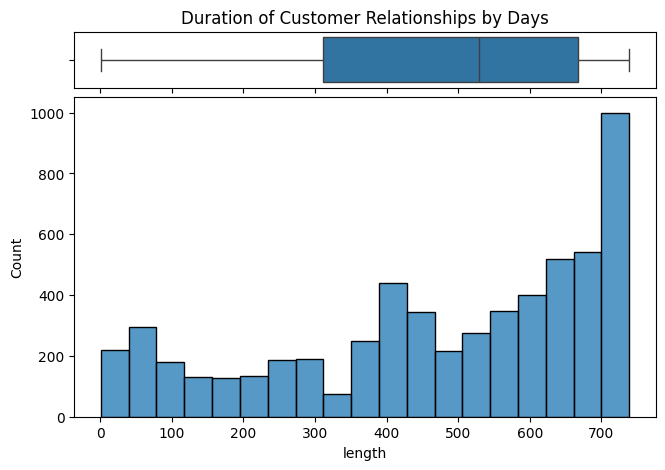

0.00      1.0
0.25    312.0
0.50    529.0
0.75    667.0
1.00    739.0
Name: length, dtype: float64

In [31]:
fig, (ax_top, ax_bot) = plt.subplots(
                            nrows=2, 
                            ncols=1, 
                            figsize=(7.5, 5),
                            gridspec_kw={
                                'height_ratios': (0.15, 0.85),
                                'hspace': 0.05
                            }
                        )

sns.boxplot(data=df_customer, x='length', ax=ax_top)
sns.histplot(data=df_customer, x='length', ax=ax_bot)

ax_top.set(
    title='Duration of Customer Relationships by Days'
)

plt.show()
display(df_customer['length'].quantile([0, 0.25, 0.5, 0.75, 1]))

In [32]:
pd.qcut(df_customer['length'], q=4)

CustomerID
12346    (529.0, 667.0]
12347    (312.0, 529.0]
12348    (312.0, 529.0]
12349    (529.0, 667.0]
12350    (0.999, 312.0]
              ...      
18283    (529.0, 667.0]
18284    (312.0, 529.0]
18285    (529.0, 667.0]
18286    (667.0, 739.0]
18287    (529.0, 667.0]
Name: length, Length: 5869, dtype: category
Categories (4, interval[float64, right]): [(0.999, 312.0] < (312.0, 529.0] < (529.0, 667.0] < (667.0, 739.0]]

Berdasarkan distribusi di atas, kita akan kelompokkan customer berdasarkan `length`-nya ke dalam 4 kelompok yaitu :
- 4 (Loyalist) : telah bergabung lebih dari 667 hari
- 3 (Active Member) : telah bergabung antara 529 hingga 667 hari terakhir
- 2 (Explorer) : telah bergabung antara 312 hingga 529 hari terakhir
- 1 (Newcomer) : baru bergabung antara 1 hingga 312 hari terakhir

In [33]:
df_customer['l_score'] = pd.qcut(
    df_customer['length'],
    q=4,                                # dibagi menjadi 4 kelompok sama banyak
    labels=[1, 2, 3, 4]                 # pelabelan untuk length: semakin lama, maka semakin besar skornya
).astype(int)

df_customer.sample(5, random_state=13)

,length,recency,frequency,monetary,l_score
CustomerID,,,,,
15639,605,134,3,1065.08,3
15339,669,66,7,1827.84,4
17861,730,3,18,5122.74,4
12365,291,291,2,641.38,1
14824,637,10,10,4022.91,3


#### **Recency Segmentation**

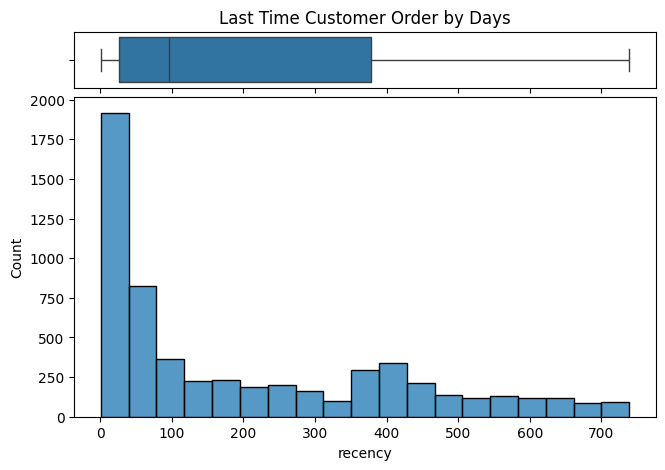

0.00      1.0
0.25     26.0
0.50     96.0
0.75    379.0
1.00    739.0
Name: recency, dtype: float64

In [34]:
fig, (ax_top, ax_bot) = plt.subplots(
                            nrows=2, 
                            ncols=1, 
                            figsize=(7.5, 5),
                            gridspec_kw={
                                'height_ratios': (0.15, 0.85),
                                'hspace': 0.05
                            }
                        )

sns.boxplot(data=df_customer, x='recency', ax=ax_top)
sns.histplot(data=df_customer, x='recency', ax=ax_bot)

ax_top.set(
    title='Last Time Customer Order by Days'
)

plt.show()
display(df_customer['recency'].quantile([0, 0.25, 0.5, 0.75, 1]))

In [35]:
pd.qcut(df_customer['recency'], q=4)

CustomerID
12346     (96.0, 379.0]
12347     (0.999, 26.0]
12348      (26.0, 96.0]
12349     (0.999, 26.0]
12350     (96.0, 379.0]
              ...      
18283     (0.999, 26.0]
18284    (379.0, 739.0]
18285    (379.0, 739.0]
18286    (379.0, 739.0]
18287      (26.0, 96.0]
Name: recency, Length: 5869, dtype: category
Categories (4, interval[float64, right]): [(0.999, 26.0] < (26.0, 96.0] < (96.0, 379.0] < (379.0, 739.0]]

Berdasarkan distribusi di atas, kita akan kelompokkan customer berdasarkan `recency`-nya ke dalam 4 kelompok yaitu :
- 4 (Active) : melakukan transaksi kurang dari 26 hari terakhir
- 3 (Warm) : melakukan transaksi antara 26 hingga 96 hari terakhir
- 2 (At-Risk) : melakukan transaksi antara 96 hingga 379 hari terakhir
- 1 (Churned) : melakukan transaksi lebih dari 379 hari terakhir

In [36]:
df_customer['r_score'] = pd.qcut(
    df_customer['recency'],
    q=4,                                # dibagi menjadi 4 kelompok sama banyak
    labels=[4, 3, 2, 1]                 # pelabelan untuk recency: semakin kecil, maka semakin besar skornya
).astype(int)

df_customer.sample(5, random_state=13)

,length,recency,frequency,monetary,l_score,r_score
CustomerID,,,,,,
15639,605,134,3,1065.08,3,2
15339,669,66,7,1827.84,4,3
17861,730,3,18,5122.74,4,4
12365,291,291,2,641.38,1,2
14824,637,10,10,4022.91,3,4


#### **Frequency Segmentation**

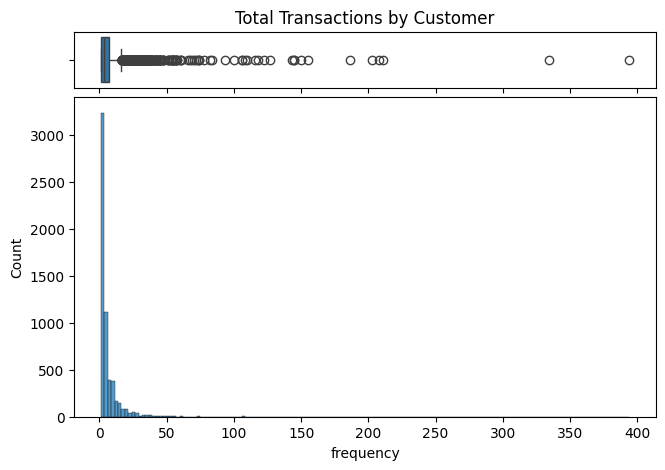

0.00      1.0
0.25      1.0
0.50      3.0
0.75      7.0
1.00    394.0
Name: frequency, dtype: float64

In [37]:
fig, (ax_top, ax_bot) = plt.subplots(
                            nrows=2, 
                            ncols=1, 
                            figsize=(7.5, 5),
                            gridspec_kw={
                                'height_ratios': (0.15, 0.85),
                                'hspace': 0.05
                            }
                        )

sns.boxplot(data=df_customer, x='frequency', ax=ax_top)
sns.histplot(data=df_customer, x='frequency', ax=ax_bot)

ax_top.set(
    title='Total Transactions by Customer'
)

plt.show()
display(df_customer['frequency'].quantile([0, 0.25, 0.5, 0.75, 1]))

Berdasarkan distribusi di atas, kita akan kelompokkan customer berdasarkan `frequency`-nya ke dalam 4 kelompok mengacu pada jumlah transaksi yang kita tentukan yaitu:
- 4 (Champion) : melakukan transaki lebih dari 7 kali
- 3 (Frequent Buyer) : melakukan transaksi 4 hingga 7 kali
- 2 (Occasional) : melakukan transaksi 2 hingga 3 kali
- 1 (First-Time Buyer) : melakukan transaksi hanya 1 kali.

In [38]:
def f_score(x):
    if x == 1:
        return 1
    elif x <= 3:
        return 2
    elif x <= 7:
        return 3
    else:
        return 4
    
df_customer['f_score'] = df_customer['frequency'].apply(f_score)
df_customer.sample(5, random_state=13)

,length,recency,frequency,monetary,l_score,r_score,f_score
CustomerID,,,,,,,
15639,605,134,3,1065.08,3,2,2
15339,669,66,7,1827.84,4,3,3
17861,730,3,18,5122.74,4,4,4
12365,291,291,2,641.38,1,2,2
14824,637,10,10,4022.91,3,4,4


#### **Monetary Segmentation**

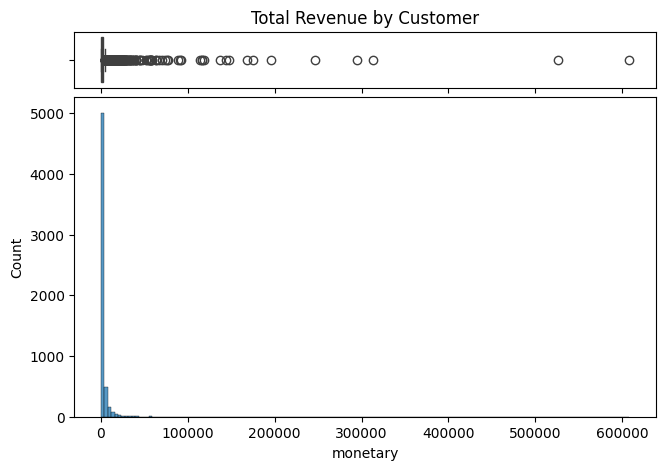

0.00         0.00
0.25       346.49
0.50       883.73
0.75      2297.66
1.00    607967.25
Name: monetary, dtype: float64

In [39]:
fig, (ax_top, ax_bot) = plt.subplots(
                            nrows=2, 
                            ncols=1, 
                            figsize=(7.5, 5),
                            gridspec_kw={
                                'height_ratios': (0.15, 0.85),
                                'hspace': 0.05
                            }
                        )

sns.boxplot(data=df_customer, x='monetary', ax=ax_top)
sns.histplot(data=df_customer, x='monetary', ax=ax_bot)

ax_top.set(
    title='Total Revenue by Customer'
)

plt.show()
display(df_customer['monetary'].quantile([0, 0.25, 0.5, 0.75, 1]))

Berdasarkan distribusi di atas, kita akan kelompokkan customer berdasarkan `monetary`-nya ke dalam 4 kelompok yaitu :
- 4 (VIP) : melakukan transaksi lebih dari **£2297.66**
- 3 (Valuable) : melakukan transaksi antara **£883.73** hingga **£2297.66**
- 2 (Average) : melakukan transaksi antara **£346.49** hingga **£883.73**
- 1 (Low Value) : melakukan transaksi kurang dari dari **£346.49**

In [40]:
df_customer['m_score'] = pd.qcut(
    df_customer['monetary'],
    q=4,                                # dibagi menjadi 4 kelompok sama banyak
    labels=[1, 2, 3, 4]                 # pelabelan untuk monetary: semakin besar, maka semakin besar skornya
).astype(int)

df_customer.sample(5, random_state=13)


,length,recency,frequency,monetary,l_score,r_score,f_score,m_score
CustomerID,,,,,,,,
15639,605,134,3,1065.08,3,2,2,3
15339,669,66,7,1827.84,4,3,3,3
17861,730,3,18,5122.74,4,4,4,4
12365,291,291,2,641.38,1,2,2,2
14824,637,10,10,4022.91,3,4,4,4


### `Inspecting Anomalies`

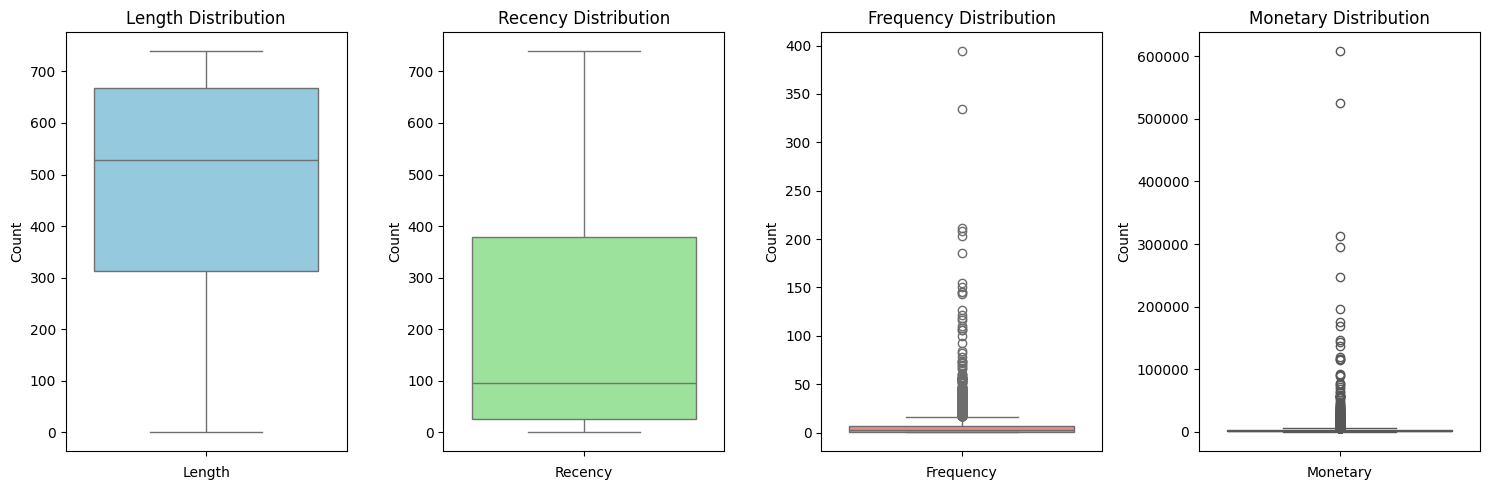

In [41]:
fig, ax = plt.subplots(1,4, figsize=(15, 5))

sns.boxplot(df_customer['length'], color='skyblue', ax=ax[0])
ax[0].set_title('Length Distribution')
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Count')

sns.boxplot(df_customer['recency'], color='lightgreen', ax=ax[1])
ax[1].set_title('Recency Distribution')
ax[1].set_xlabel('Recency')
ax[1].set_ylabel('Count')

sns.boxplot(df_customer['frequency'], color='salmon', ax=ax[2])
ax[2].set_title('Frequency Distribution')
ax[2].set_xlabel('Frequency')
ax[2].set_ylabel('Count')

sns.boxplot(df_customer['monetary'], color='royalblue', ax=ax[3])
ax[3].set_title('Monetary Distribution')
ax[3].set_xlabel('Monetary')
ax[3].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [42]:
F_Q1 = df_customer['frequency'].quantile(0.25)
F_Q3 = df_customer['frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1

frequency_outliers_df = df_customer[(df_customer['frequency'] > (F_Q3 + 1.5 * F_IQR)) | (df_customer['frequency'] < (F_Q1 - 1.5 * F_IQR))].copy()

frequency_outliers_df.describe()

,length,recency,frequency,monetary,l_score,r_score,f_score,m_score
count,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.0,426.000000
mean,676.091549,31.333333,34.967136,21250.257042,3.598592,3.678404,4.0,3.997653
std,103.405807,68.857375,35.446514,49612.309221,0.729801,0.634204,0.0,0.048450
min,102.000000,1.000000,17.000000,1820.440000,1.000000,1.000000,4.0,3.000000
25%,658.000000,4.000000,20.000000,6422.767500,3.000000,4.000000,4.0,4.000000
50%,726.000000,10.000000,25.000000,9771.465000,4.000000,4.000000,4.0,4.000000
75%,735.750000,25.000000,35.000000,16939.505000,4.000000,4.000000,4.0,4.000000
max,739.000000,576.000000,394.000000,607967.250000,4.000000,4.000000,4.0,4.000000


In [43]:
M_Q1 = df_customer['monetary'].quantile(0.25)
M_Q3 = df_customer['monetary'].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = df_customer[(df_customer['monetary'] > (M_Q3 + 1.5 * M_IQR)) | (df_customer['monetary'] < (M_Q1 - 1.5 * M_IQR))].copy()

monetary_outliers_df.describe()

,length,recency,frequency,monetary,l_score,r_score,f_score,m_score
count,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.0
mean,652.182692,53.514423,26.000000,18331.807147,3.458333,3.467949,3.870192,4.0
std,126.337970,105.740846,31.742847,41908.354725,0.814118,0.802643,0.447008,0.0
min,3.000000,1.000000,1.000000,5232.230000,1.000000,1.000000,1.000000,4.0
25%,628.000000,5.000000,12.000000,6602.862500,3.000000,3.000000,4.000000,4.0
50%,702.500000,17.000000,18.000000,9160.730000,4.000000,4.000000,4.000000,4.0
75%,733.000000,49.000000,29.000000,14535.792500,4.000000,4.000000,4.000000,4.0
max,739.000000,692.000000,394.000000,607967.250000,4.000000,4.000000,4.000000,4.0


---

**Outlier tidak dihapus dari dataset**. Sebaliknya, mereka dipertahankan karena berpotensi merepresentasikan segmen pelanggan bernilai tinggi atau ekstrem yang relevan secara bisnis

---

### `Labelling Segmentations` **(KMeans Clustering)**

#### `K-Best`

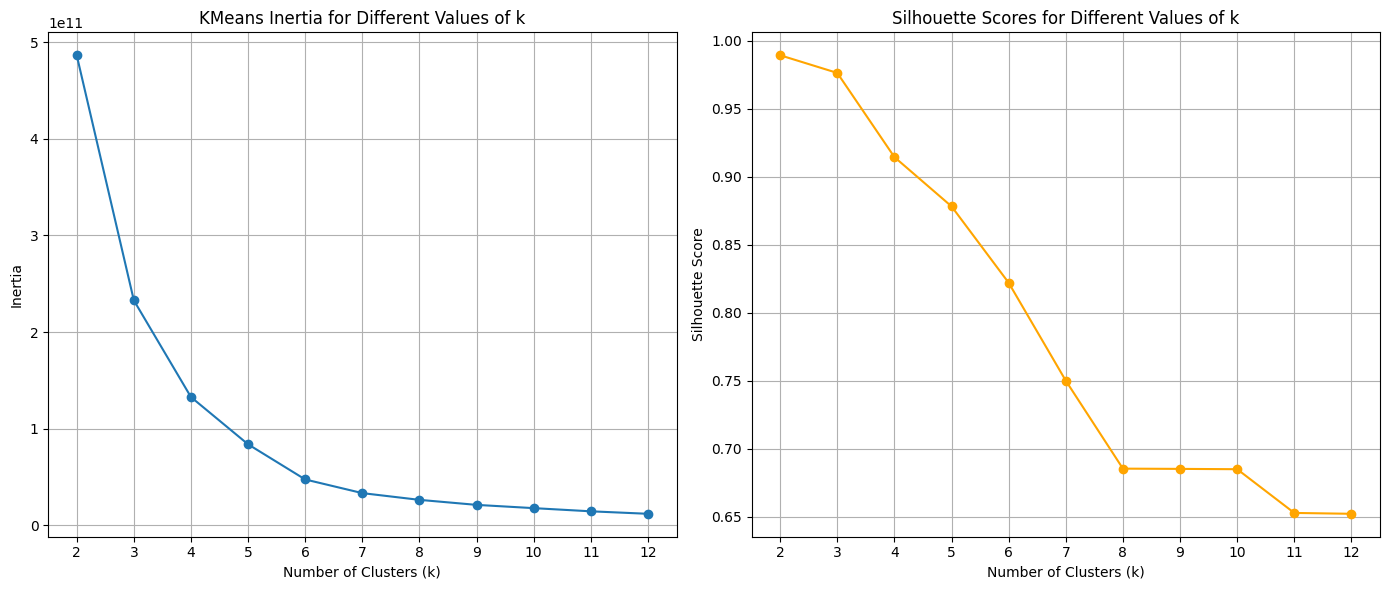

In [44]:
max_k = 12

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=13, max_iter=1000)

    cluster_labels = kmeans.fit_predict(df_customer)

    sil_score = silhouette_score(df_customer, cluster_labels)

    silhoutte_scores.append(sil_score)

    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

`K = 4` memberikan keseimbangan terbaik antara:

* Inertia yang cukup rendah, menunjukkan distribusi data yang baik dalam klaster

* Silhouette Score yang masih tinggi, mengindikasikan bahwa klaster masih kompak dan terpisah dengan jelas

In [45]:
model = KMeans(n_clusters=4, random_state=13, max_iter=1000)

# fitting model
model.fit(df_customer.loc[:, 'length':'monetary'])

# menambahkan label
df_customer['lrfm_segment_clustering'] = model.labels_.astype(str)
df_customer.sample(5, random_state=13)

,length,recency,frequency,monetary,l_score,r_score,f_score,m_score,lrfm_segment_clustering
CustomerID,,,,,,,,,
15639,605,134,3,1065.08,3,2,2,3,0
15339,669,66,7,1827.84,4,3,3,3,0
17861,730,3,18,5122.74,4,4,4,4,0
12365,291,291,2,641.38,1,2,2,2,0
14824,637,10,10,4022.91,3,4,4,4,0


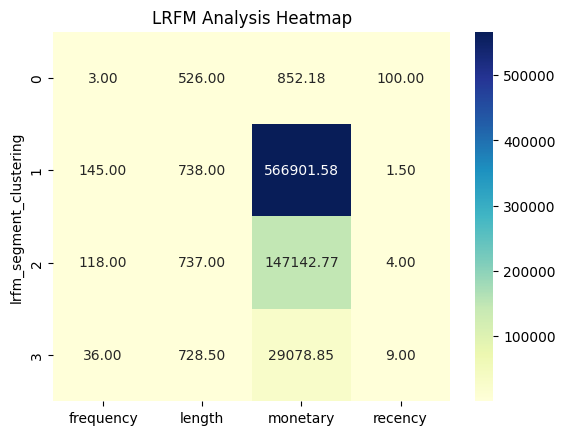

In [46]:
lrfm_heatmap = df_customer.pivot_table(index='lrfm_segment_clustering', values=['length', 'recency', 'frequency', 'monetary'], aggfunc='median')

sns.heatmap(lrfm_heatmap, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('LRFM Analysis Heatmap')
plt.show()

In [47]:
color_map = {
    '0' : 'red',
    '1' : 'green',
    '2' : 'blue',
    '3' : 'black',
}

fig = px.scatter_3d(
    df_customer, 
    x='recency', 
    y='frequency', 
    z='monetary',
    color='lrfm_segment_clustering', 
    color_discrete_map=color_map, 
)
                          
fig.update_traces(marker_size = 3)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),
                  title={
                    'text': "RFM segmentation",
                    'y':0.97,
                    'x':0.45,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                    legend=dict(
                      yanchor="top",
                      y=0.97,
                      xanchor="left",
                      x=0.70,
                      itemsizing='constant',
                      itemwidth = 30))

fig.update_xaxes(tickformat=".0f")

### `Summary & Recommendations`

---

Rekomendasi untuk masing-masing segmen hasil clustering (LRFM) berdasarkan nilai median (heatmap):

##### 🟥 `Segment 0 (Merah) — "At Risk"`

* `Frequency` dan `Monetary` sangat rendah (**3 kali belanja, total £852**)
* `Recency` cukup tinggi (**100 hari**) → sudah lama tidak bertransaksi
* ⚠️ Termasuk kategori **Churned Customers** yang jarang bertransaksi
* 🎯 **Strategi:** Lakukan **re-engagement campaign** seperti email reminder, promo welcome back, atau edukasi produk agar mereka kembali aktif

##### 🟩 `Segment 1 (Hijau) — "VIP"`

* `Frequency` sangat tinggi (**145 transaksi**), `Monetary` sangat besar (**£566,901**), dan `Length` tertinggi (**738 hari**)
* `Recency` sangat rendah (**1.5 hari**) → **baru saja bertransaksi**
* ✅ Merupakan **Champion Customer** yang sangat aktif, loyal, dan bernilai tinggi
* 🎯 **Strategi:** Berikan **program loyalitas eksklusif**, promo khusus VIP, dan treatment premium untuk mempertahankan loyalitas mereka

##### 🟦 `Segment 2 (Biru) — "Retain"`

* `Frequency` cukup tinggi (**118 transaksi**), `Monetary` besar (**£147,142**)
* `Recency` rendah (**4 hari**) dan `Length` panjang (**737 hari**)
* ✅ Ini adalah **High-Value Customer** yang konsisten dan stabil
* 🎯 **Strategi:** Jaga loyalitas dengan **penawaran personalisasi**, newsletter berkala, dan akses prioritas produk

##### ⬛ `Segment 3 (Hitam) — "Re-Engage"`

* `Frequency` menengah (**36 transaksi**), `Monetary` rendah (**£29,078**), `Recency` masih wajar (**9 hari**)
* `Length` panjang (**728 hari**) → pelanggan lama tapi nilai transaksinya kecil
* ⚠️ Termasuk kategori **casual buyer** atau pelanggan yang mengalami penurunan aktivitas
* 🎯 **Strategi:** Dorong pembelian ulang melalui **diskon berkala**, rekomendasi produk, atau upsell dari histori pembelian

---

##### 🧠 Ringkasan Nama dan Tujuan Segmentasi

| Segment | Warna | Strategis      | Fokus Utama                                   |
| ------- | ----- | -------------- | --------------------------------------------- |
| 0       | Merah | **Churned**    | Re-engagement strategy                        |
| 1       | Hijau | **VIP**        | Reward & retain pelanggan terbaik             |
| 2       | Biru  | **Retain**     | Jaga konsistensi pelanggan setia              |
| 3       | Hitam | **Re-Engage**  | Dorong interaksi ulang dari pelanggan pasif   |

---